# Funnel Target: Compare SGLD and NVGD

In [1]:
%load_ext autoreload
from jax import config
config.update("jax_debug_nans", False)
# config.update("jax_disable_jit", True)

import sys
import os
sys.path.append("../../learning_particle_gradients/")
from matplotlib.animation import FuncAnimation

import jax.numpy as np
import jax.numpy as jnp
from jax import grad, jit, vmap, random, lax, jacfwd, value_and_grad
from jax.ops import index_update, index
import matplotlib.pyplot as plt
import matplotlib
import numpy as onp
import jax
import pandas as pd

import utils
import plot
import distributions
import models
import flows
from tqdm import tqdm
import optax
key = random.PRNGKey(0)

import kernels
import metrics
# import seaborn as sns
# sns.set_theme()

# 2dim Funnel

In [2]:
##### sorta works:
# STEP_SIZE = 1e-2
# META_LEARNING_RATE = 1e-4
# d = 2
# PATIENCE = -1
# # PATIENCE = 15 # try this
# NUM_SAMPLES = 200
# MAX_TRAIN_STEPS = 100
# NUM_ITER = 500

In [3]:
STEP_SIZE = 1e-2
META_LEARNING_RATE = 1e-4
d = 2
PATIENCE = 15
NUM_SAMPLES = 100
MAX_TRAIN_STEPS = 50
NUM_ITER = 5000

In [4]:
target = distributions.Funnel(d)
proposal = distributions.Gaussian(np.zeros(d), np.ones(d))
funnel_setup = distributions.Setup(target, proposal)
target_samples = target.sample(NUM_SAMPLES)
compute_metrics = metrics.get_funnel_tracer(target_samples)

In [8]:
key, subkey = random.split(key)
init_particles = proposal.sample(NUM_SAMPLES)

opt = optax.sgd(STEP_SIZE)
sgld = utils.sgld(STEP_SIZE/10)
sgld_state = sgld.init(init_particles)
sgld_full = utils.sgld(STEP_SIZE)
sgld_full_state = sgld_full.init(init_particles)

key, subkey1, subkey2 = random.split(key, 3)
neural_grad = models.SDLearner(target_dim=init_particles.shape[1],
                               learning_rate=META_LEARNING_RATE,
                               key=subkey1,
                               sizes=[32, 32, init_particles.shape[1]],
                               aux=False,
                               use_hutchinson=False,
                               patience=PATIENCE,
                               dropout=False)

particles = models.Particles(subkey2,
                             neural_grad.gradient,
                             init_particles,
                             custom_optimizer=opt,
                             compute_metrics=compute_metrics)

In [9]:
key, subkey = random.split(key)
vdlogp = jit(vmap(grad(target.logpdf)))


def nvgd_step(split_particles, split_dlogp):
    neural_grad.train(
        split_particles=split_particles,
        split_dlogp=split_dlogp,
        n_steps=MAX_TRAIN_STEPS
    )
    particles.step(neural_grad.get_params())


@jit
def sgld_step(particles, dlogp, sgld_state):
    """Update param_set elements in parallel using Langevin dynamics."""
    g, sgld_state = sgld.update(-dlogp, sgld_state, particles)
    particles = optax.apply_updates(particles, g)
    aux = {
        "global_grad_norm": optax.global_norm(g),
    }
    return particles, sgld_state, aux

@jit
def sgld_full_step(particles, dlogp, sgld_full_state):
    """Update param_set elements in parallel using Langevin dynamics."""
    g, sgld_state = sgld_full.update(-dlogp, sgld_full_state, particles)
    particles = optax.apply_updates(particles, g)
    aux = {
        "global_grad_norm": optax.global_norm(g),
    }
    aux.update(compute_metrics(particles))
    return particles, sgld_state, aux

* test: without sgld (same as in other notebook?? hopefully)
* THEN: test with sgld (less overfitting? less noise in MMD??)
* THEN: test with reset after each step.

In [10]:
sgld_aux = {}
for step_counter in tqdm(range(NUM_ITER)):
    key, subkey = random.split(key)
    split_particles = particles.next_batch(subkey)
    split_dlogp = [vdlogp(xs) for xs in split_particles]

    # NVGD
    nvgd_step(split_particles, split_dlogp)

#     # SGLD step
#     particles.particles, sgld_state, aux = sgld_step(
#         particles.particles, jnp.append(*split_dlogp, axis=0), sgld_state)
#     metrics.append_to_log(sgld_aux, aux)

# neural_grad.done()
# particles.done()

100%|██████████| 5000/5000 [04:15<00:00, 19.58it/s]


NameError: name 'sgld_full_aux' is not defined

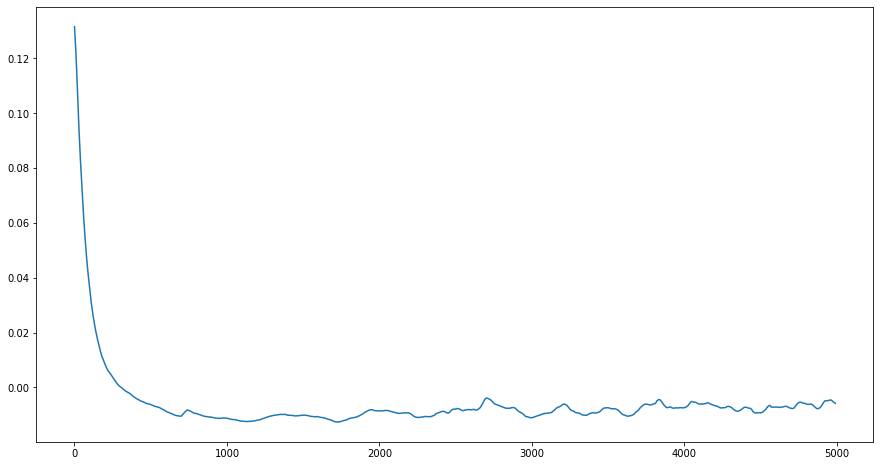

In [11]:
%matplotlib inline
plt.subplots(figsize=[15, 8])

typ = "funnel_mmd"
plt.plot(*zip(*particles.rundata[typ]), label="NVGD")
plt.plot(sgld_full_aux[typ], label="SGLD")
plt.legend()

In [ ]:
%matplotlib inline
fig, axs = plt.subplots(2, 1, figsize = [8,8])

ax = axs[0]
ax.plot(particles.rundata['global_grad_norm_post_update'], label="NVGD update norm")
# ax.plot(sgld_aux['global_grad_norm'], label="SGLD update norm")
ax.set_yscale('log')
ax.legend()

ax = axs[1]
ax.plot(neural_grad.rundata["training_loss"])
ax.plot(neural_grad.rundata["validation_loss"])

In [ ]:
# generate markings based on num_steps
%matplotlib inline
fig, ax = plt.subplots(figsize = [18,8])
a = 80000
b = 85000

markings = onp.cumsum(neural_grad.rundata['train_steps'])
marker_a = (markings < a).sum()
marker_b = (markings < b).sum()
print(f"step {marker_a} to step {marker_b}.")

ax.plot(neural_grad.rundata["training_loss"][a:b], "--.")
ax.plot(neural_grad.rundata["validation_loss"][a:b], "--.")
ax.scatter(markings[marker_a:marker_b] - a, onp.zeros(marker_b - marker_a), color="black")

In [ ]:
# just sgld
sgld_particles = init_particles
sgld_trajectory = [sgld_particles]
sgld_full_aux = {}
for step_counter in tqdm(range(NUM_ITER)):
    dlogp = vdlogp(sgld_particles)
    sgld_particles, sgld_full_state, aux = sgld_full_step(
        sgld_particles, dlogp, sgld_full_state)
    metrics.append_to_log(sgld_full_aux, aux)
    sgld_trajectory.append(sgld_particles)

# neural_grad.done()
# particles.done()

In [ ]:
%matplotlib inline
fig, axs = plt.subplots(1, 3, figsize=[22, 6])

ax = axs[0]
plot.scatter(particles.particles, ax=ax, label="SGLD")
plot.scatter(sgld_particles, ax=ax, label="NVGD")

ax = axs[1]
typ = "funnel_mmd"
ax.plot(*zip(*particles.rundata[typ]), label="NVGD")
ax.plot(sgld_full_aux[typ], label="SGLD")
ax.legend()

ax = axs[2]
typ = "rbf_mmd"
ax.plot(*zip(*particles.rundata[typ]), label="NVGD")
ax.plot(sgld_full_aux[typ], label="SGLD")
ax.legend()

In [ ]:
plt.subplots(figsize=[15, 8])

typ = "rbf_mmd"
plt.plot(*zip(*particles.rundata[typ]), label="NVGD")
plt.plot(sgld_full_aux[typ], label="SGLD")
plt.legend()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

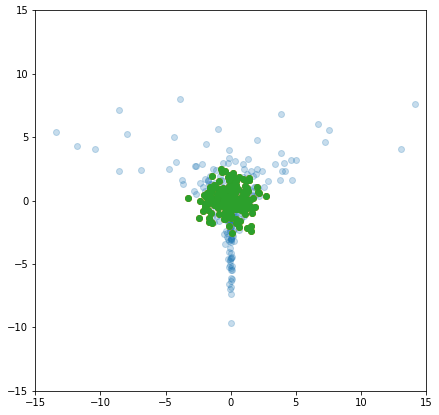

In [11]:
%matplotlib widget
lims = (-15, 15)
fig, ax = plt.subplots(figsize=[7,7])
ax.scatter(*np.rollaxis(target.sample(NUM_SAMPLES), 1), label="True", alpha=0.25)
ax.set(xlim=lims, ylim=lims)


interval = 10
nvgd_traj = onp.array(particles.rundata['particles'])
sgld_traj = onp.array(sgld_trajectory)
a = []
a.append(plot.animate_array(nvgd_traj, fig, ax=ax, interval=interval))
a.append(plot.animate_array(sgld_traj, fig, ax=ax, interval=interval))
a